# Compare reads classification from Kraken2
Aims to extract results from kraken2 reports, to present and compare results between batches
Sylvain @ GIS / Biopolis / Singapore
<Riondet_Sylvain_from.tp@gis.a-star.edu.sg>

Started on 2019-11-28

todo: bars in pandas tables <br>
http://pandas.pydata.org/pandas-docs/stable/user_guide/style.html

In [2]:
import os
import pandas as pd
import os.path as osp
import ete3.ncbi_taxonomy

In [3]:
from sklearn.metrics import auc, average_precision_score, roc_auc_score
import matplotlib.pyplot as plt

In [4]:
ncbi = ete3.ncbi_taxonomy.NCBITaxa()

In [5]:
pd.set_option('precision', 2)

In [6]:
# folder_isolates = "~/Data/ONT_fastq/"
folder_reports = "/home/ubuntu/Disks/HDD1000/Reports/2019-12-05_100000-WindowReads_20-BacGut"

In [7]:
def get_desired_ranks(taxid, desired_ranks, tolist=False):
    """ From stackoverflow
        https://stackoverflow.com/questions/36503042/how-to-get-taxonomic-specific-ids-for-kingdom-phylum-class-order-family-gen
    """
    try:
        lineage = ncbi.get_lineage(taxid)
        lineage2ranks = ncbi.get_rank(lineage)
        ranks2lineage = dict((rank, taxid) for (taxid, rank) in lineage2ranks.items())
        if tolist: return [ranks2lineage.get(rank, 0) for rank in desired_ranks]
        else:      return {f'{rank}_id': ranks2lineage.get(rank, 0) for rank in desired_ranks}
    except:
        print(f"retrieval of the lineage of {taxid} failed")
        if tolist: return [0 for rank in desired_ranks]
        else:      return {f'{rank}_id': 0 for rank in desired_ranks}

In [8]:
def get_list_rank(taxids, desired_rank="species"):
    res = []
    for taxid in taxids:
        name = get_desired_ranks(taxid, [desired_rank], tolist=True)[0]
        res.append(name)
    return res

In [9]:
def div_z(n, d):
    return n / d if d else 0

In [10]:
class Report:
    
    def __init__(self, folder, filename, bin_full, nb_reads=None):
        self.folder      = folder
        self.filename    = filename
        self.bin_full    = bin_full  # either "full" or "bins"
        self.nb_reads    = nb_reads
        self.report      = None
        self.all_reports = None
        
        self.recall      = None
        self.precision   = None
        self.auc         = None
        
        self.load()
        
    def load(self, ):
        """Load and filter to species only"""
        if self.bin_full == "full":
            self.report = pd.read_csv(osp.join(self.folder, self.filename), sep="\t", names=[
                "%_clade_covered", "reads_clade_covered", "reads_direct_taxo", "Rank", "NCBI_Taxo_id", "Scientific_name"])
            self.report = self.report[self.report["Rank"]=="S"].sort_values(by=["%_clade_covered"], ascending=False)
            
        elif self.bin_full == "bins":
            self.aggregate_bins()
        else:
            raise NotImplementedError(f"'{self.bin_full}' isn't implemented")
        
    def aggregate_bins(self):
        """ Reports should have an identifier <.full.> or <.bin-x.> to identify them """
        
        assert self.nb_reads != 0, "The total number of reads is necessary to load and compute for bins stats"
        reports_bins = []
        bins = []
        for rep in self.filename:
            tmp_df = pd.read_csv(osp.join(self.folder, rep), sep="\t", names=[
                "%_clade_covered", "reads_clade_covered", "reads_direct_taxo", "Rank", "NCBI_Taxo_id", "Scientific_name"])
            tmp_df["bin"] = int(rep.split(".bin-")[1].split(".")[0])
            reports_bins.append(tmp_df)
        report_bins = pd.concat(reports_bins, ignore_index=True)
        
        self.all_reports = report_bins[report_bins.Rank == "S"].sort_values("reads_clade_covered", ascending=False)
        aggregated_bins  = self.all_reports.groupby("NCBI_Taxo_id").agg('sum').sort_values("reads_clade_covered", ascending=False)
        aggregated_bins["Scientific_name"] = ncbi.translate_to_names(aggregated_bins.index)
        aggregated_bins["%_clade_covered"] = aggregated_bins.reads_clade_covered / self.nb_reads * 100
        aggregated_bins.drop(columns=["bin"], inplace=True)
        aggregated_bins.reset_index(inplace=True)
        self.report = aggregated_bins
        
    def assigned_reads(self):
        return self.report["%_clade_covered"].sum()
    
    def prec_recall(self, gt_species):
        thresholds = self.report["%_clade_covered"].round(2).unique()
        thresholds.sort()
        data = []

        for i, threshold in enumerate(thresholds):
            found = set(self.report[self.report["%_clade_covered"] >= threshold].NCBI_Taxo_id)
            tp = len(set.intersection(found, gt_species))
            fn = len(gt_species) - tp
            fp = len(found) - tp
            data.append((threshold, tp, fn, fp, ))
            
        df_auc = pd.DataFrame(data, columns=["threshold", "tp", "fn", "fp"])
        df_auc["recall"] = df_auc.tp / (df_auc.tp + df_auc.fn)
        df_auc["precision"] = df_auc.tp / (df_auc.tp + df_auc.fp)
        df_auc[["recall", "precision"]] = df_auc[["recall", "precision"]].fillna(0)
        self.recall = df_auc["recall"].tolist()
        self.precision = df_auc["precision"].tolist()
        self.auc = auc(self.recall, self.precision)

    def plot_pr(self):
        plt.plot(self.recall, self.precision)
        plt.axis([0, 1, 0, 1])
        
    def __repr__(self):
        return f"Report from {self.bin_full} DB classification, {self.filename}"

In [35]:
class ReportsAnalysis:
    
    
    def __init__(self, folder, string_full, string_bins, path_ground_truth):
        """ string* are matching string to find the full and bin reports """
        self.folder         = folder
        self.string_full    = string_full
        self.string_bins    = string_bins
        self.path_ground_truth    = path_ground_truth
        self.path_report_full     = ""
        self.path_report_bins     = ""
        
        self.selected_r     = None
        self.gt             = None
        self.gt_stats       = None
        self.reports        = {}
        
        self.nb_reads       = None
        self.gt_species     = None
        self.auc            = None
        self._recall        = {}
        self._precision     = {}
        
    @property
    def report(self):
        if self.selected_r is None:
            self.selected_r = 0
        if self.selected_r in self.reports.keys(): 
            return self.reports[self.selected_r]
        else:
            return None
    
    @property
    def recall(self):
        if self.selected_r not in self._recall.keys():
            return None
        else:
            return self._recall[self.selected_r]
    
    @property
    def precision(self):
        if self.selected_r not in self._precision.keys():
            return None
        else:
            return self._precision[self.selected_r]
        
    def load_gt(self):
        self.gt = pd.read_pickle(self.path_ground_truth)
        self.nb_reads = self.gt.shape[0]
        self.gt["count"] = 1
        gt_stats = self.gt.groupby("taxon").sum()
        gt_stats.reset_index(inplace=True)
        gt_stats["species"] = get_list_rank(gt_stats.taxon)
        gt_stats = gt_stats.groupby("species").sum()[["count"]].sort_values("count", ascending=False)
        gt_stats.reset_index(inplace=True)
        gt_stats["name"] = ncbi.translate_to_names(gt_stats.species)
        gt_stats["percentage"] = gt_stats["count"] *100 / gt_stats["count"].sum()
        self.gt_stats = gt_stats
    
    def load_reports(self):
        found = [f for f in os.listdir(self.folder) if self.string_full in f and "report" in f]
        assert len(found) == 1, f"Multiple matches ({len(found)}) for full report file, with string ({self.string_full})"
        self.reports[0] = Report(self.folder, found[0], "full")
        
        found = [f for f in os.listdir(self.folder) if self.string_bins in f and "report" in f]
        assert len(found) > 1, f"Not enough matches ({len(found)}) for bins report files, with string ({self.string_bins})"
        self.reports[1] = Report(self.folder, found, "bins", self.nb_reads)
        
    def prec_recall(self, select=-1):
        self.gt_species = set(self.gt_stats.species.unique())
        if select < 0:
            for k in self.reports.keys():
                self.reports[k].prec_recall(self.gt_species)
        else:
            self.reports[select].prec_recall(self.gt_species)
        
    def plot_pr(self):
        plt.plot(self.report.recall, self.report.precision)
        plt.axis([0, 1, 0, 1])
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"{self.report.bin_full} database, auc={self.report.auc:.2f}")

In [73]:
analysis = ReportsAnalysis(folder_reports, "full", ".bin-", 
                           "~/Data/Segmentation/Test-Data/Synthetic_from_Genomes/" \
                           "2019-12-05_100000-WindowReads_20-BacGut/2019-12-05_100000-WindowReads_20-BacGut.GT.pd")

In [74]:
analysis.load_gt()
analysis.load_reports()
analysis.prec_recall()

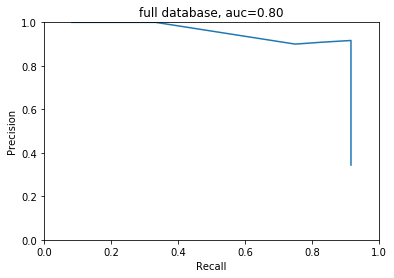

In [75]:
analysis.plot_pr()

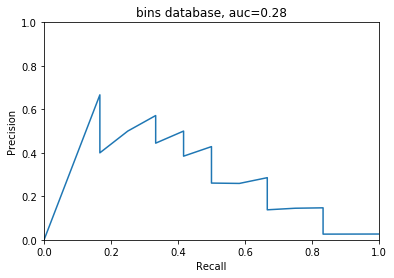

In [76]:
analysis.selected_r = 1
analysis.plot_pr()

In [77]:
collated_report = analysis.gt_stats.copy()
collated_report.set_index("species", inplace=True)

In [78]:
collated_report

,count,name,percentage
species,,,
562,15000,Escherichia coli,15.0
573,15000,Klebsiella pneumoniae,15.0
1280,15000,Staphylococcus aureus,15.0
1351,15000,Enterococcus faecalis,15.0
287,5000,Pseudomonas aeruginosa,5.0
550,5000,Enterobacter cloacae,5.0
584,5000,Proteus mirabilis,5.0
817,5000,Bacteroides fragilis,5.0
823,5000,Parabacteroides distasonis,5.0


In [79]:
rep = analysis.reports[0].report
rep.set_index("NCBI_Taxo_id", inplace=True)
collated_report["full_DB_per"] = rep["%_clade_covered"]
collated_report["full_DB_per"] = collated_report["full_DB_per"].fillna(0)

In [80]:
rep = analysis.reports[1].report
rep.set_index("NCBI_Taxo_id", inplace=True)
collated_report["bins_DB_per"] = rep["%_clade_covered"]
collated_report["bins_DB_per"] = collated_report["bins_DB_per"].fillna(0)

In [81]:
collated_report.drop(columns="count", inplace=True)

In [82]:
collated_report

,name,percentage,full_DB_per,bins_DB_per
species,,,,
562,Escherichia coli,15.0,15.08,9.70e-02
573,Klebsiella pneumoniae,15.0,14.69,6.52e+00
1280,Staphylococcus aureus,15.0,14.97,2.02e-01
1351,Enterococcus faecalis,15.0,14.81,4.90e-01
287,Pseudomonas aeruginosa,5.0,4.87,1.44e+00
550,Enterobacter cloacae,5.0,0.00,1.85e-01
584,Proteus mirabilis,5.0,5.00,2.78e+00
817,Bacteroides fragilis,5.0,5.00,8.70e-02
823,Parabacteroides distasonis,5.0,5.00,6.00e-03


In [83]:
collated_report.style.bar(subset=["percentage", "full_DB_per", "bins_DB_per"], color=['#d65f5f', '#5fba7d'],
                          vmin=0, vmax=15.5, align="left", ) \
    .set_properties(subset=['name'], **{'width': '200px'})

,name,percentage,full_DB_per,bins_DB_per
species,,,,
562,Escherichia coli,15,15,0.097
573,Klebsiella pneumoniae,15,15,6.5
1280,Staphylococcus aureus,15,15,0.2
1351,Enterococcus faecalis,15,15,0.49
287,Pseudomonas aeruginosa,5,4.9,1.4
550,Enterobacter cloacae,5,0,0.18
584,Proteus mirabilis,5,5,2.8
817,Bacteroides fragilis,5,5,0.087
823,Parabacteroides distasonis,5,5,0.006


In [84]:
collated_report.rename(columns={"percentage": "ground_truth_per"}).style.background_gradient(subset=["ground_truth_per", "full_DB_per", "bins_DB_per"], cmap="Blues").set_properties(subset=['name'], **{'width': '200px'})

,name,ground_truth_per,full_DB_per,bins_DB_per
species,,,,
562,Escherichia coli,15,15,0.097
573,Klebsiella pneumoniae,15,15,6.5
1280,Staphylococcus aureus,15,15,0.2
1351,Enterococcus faecalis,15,15,0.49
287,Pseudomonas aeruginosa,5,4.9,1.4
550,Enterobacter cloacae,5,0,0.18
584,Proteus mirabilis,5,5,2.8
817,Bacteroides fragilis,5,5,0.087
823,Parabacteroides distasonis,5,5,0.006


In [85]:
collated_report.full_DB_per.sum()

94.39

In [86]:
collated_report.bins_DB_per.sum()

13.738000000000003

In [142]:
allbins = analysis.reports[1].all_reports
allbins[allbins.NCBI_Taxo_id == 562]


,%_clade_covered,reads_clade_covered,reads_direct_taxo,Rank,NCBI_Taxo_id,Scientific_name,bin
237,0.58,60,0,S,562,Escherichia coli,1
451,0.40,37,18,S,562,Escherichia coli,2


In [194]:
analysis.reports[1].report[["%_clade_covered", "Scientific_name", "NCBI_Taxo_id"]].head(20)

,%_clade_covered,Scientific_name,NCBI_Taxo_id
0,8.24,Serratia marcescens,615
1,6.52,Klebsiella pneumoniae,573
2,2.78,Proteus mirabilis,584
3,2.18,Cronobacter sakazakii,28141
4,1.87,Edwardsiella tarda,636
5,1.44,Pseudomonas aeruginosa,287
6,1.36,Bifidobacterium longum,216816
7,0.97,Cronobacter turicensis,413502
8,0.76,[Enterobacter] lignolyticus,1334193
9,0.56,Lactobacillus plantarum,1590


In [68]:
analysis.reports[1].report.sample(10)

,NCBI_Taxo_id,%_clade_covered,reads_clade_covered,reads_direct_taxo,bin,Scientific_name
220,1314,0.02,24,14,1,Streptococcus pyogenes
94,81028,0.06,61,0,2,Treponema brennaborense
191,985002,0.03,31,31,4,Staphylococcus argenteus
101,456327,0.06,57,52,4,Xanthomonas euvesicatoria
242,59754,0.02,21,0,2,Alcanivorax borkumensis
15,1134687,0.41,406,55,6,Klebsiella michiganensis
115,29494,0.05,51,0,2,Vibrio furnissii
23,1247,0.21,209,0,1,Oenococcus oeni
17,53412,0.32,322,0,6,Pseudomonas resinovorans
145,2746,0.04,40,0,4,Halomonas elongata


In [35]:
path_report_full = osp.join(folder_reports, "2015-10bins.full.kraken2.report")
print(path_report_full, "\n has been found : ", osp.isfile(path_report_full))

path_report_bins = [osp.join(folder_reports, f) for f in os.listdir(folder_reports) if (".bin-" in f and f.endswith(".report"))]

/home/ubuntu/Disks/HDD1000/Reports/2019-12-05_100000-WindowReads_20-BacGut/2015-10bins.full.kraken2.report 
 has been found :  True


In [10]:
report_full = pd.read_csv(path_report_full, sep="\t", names=[
    "%_clade_covered", "reads_clade_covered", "reads_direct_taxo", "Rank", "NCBI_Taxo_id", "Scientific_name"])

In [11]:
ground_truth = pd.read_pickle("/home/ubuntu/Disks/HDD1000/Segmentation/Test-Data/Synthetic_from_Genomes/"\
                             "2019-12-05_100000-WindowReads_20-BacGut/2019-12-05_100000-WindowReads_20-BacGut.GT.pd")
ground_truth.sample(5)

,record_id,quality,length,taxon,name,gen_chr_plas,start,stop,description,file_path
7652,NC_017664.1,1000000,10000,566546,Escherichia coli W,complete genome,2360000,2370000,"tax_id=566546,start=2360000,Escherichia : NC_0...",/home/ubuntu/Disks/HDD1000/NCBI/20190704/refse...
16997,NZ_AP018671.1,1000000,10000,573,Klebsiella pneumoniae,complete genome,5080000,5090000,"tax_id=573,start=5080000,Klebsiella : NZ_AP018...",/home/ubuntu/Disks/HDD1000/NCBI/20190704/refse...
47980,NC_010498.1,1000000,10000,439855,Escherichia coli SMS-3-5,complete genome,4730000,4740000,"tax_id=439855,start=4730000,Escherichia : NC_0...",/home/ubuntu/Disks/HDD1000/NCBI/20190704/refse...
73457,NC_011593.1,1000000,10000,391904,Bifidobacterium longum subsp. infantis ATCC 15...,complete genome,1090000,1100000,"tax_id=391904,start=1090000,Bifidobacterium : ...",/home/ubuntu/Disks/HDD1000/NCBI/20190704/refse...
37716,NZ_CP018695.1,1000000,10000,573,Klebsiella pneumoniae,complete genome,3540000,3550000,"tax_id=573,start=3540000,Klebsiella : NZ_CP018...",/home/ubuntu/Disks/HDD1000/NCBI/20190704/refse...


In [12]:
gt_stats = ground_truth.groupby("taxon").count()[["record_id"]]
gt_stats.rename(columns={"record_id": "counts"}, inplace=True)
gt_stats.reset_index(inplace=True)

In [13]:
gt_stats["ratio"] = gt_stats.counts / gt_stats.counts.sum()

In [14]:
gt_stats

,taxon,counts,ratio
0,287,5000,0.05
1,562,5000,0.05
2,573,15000,0.15
3,1280,10000,0.10
4,1351,10000,0.10
5,1590,5000,0.05
6,46170,5000,0.05
7,195102,5000,0.05
8,295405,5000,0.05
9,391904,5000,0.05


#### Kraken Report format
1. Percentage of fragments covered by the clade rooted at this taxon
2. Number of fragments covered by the clade rooted at this taxon
3. Number of fragments assigned directly to this taxon
4. A rank code, indicating (U)nclassified, (R)oot, (D)omain, (K)ingdom,
   (P)hylum, (C)lass, (O)rder, (F)amily, (G)enus, or (S)pecies.
   Taxa that are not at any of these 10 ranks have a rank code that is
   formed by using the rank code of the closest ancestor rank with
   a number indicating the distance from that rank.  E.g., "G2" is a
   rank code indicating a taxon is between genus and species and the
   grandparent taxon is at the genus rank.
5. NCBI taxonomic ID number
6. Indented scientific name

In [15]:
report_full = report_full[report_full["Rank"]=="S"].sort_values(by=["%_clade_covered"], ascending=False)
report_full.head(10)

,%_clade_covered,reads_clade_covered,reads_direct_taxo,Rank,NCBI_Taxo_id,Scientific_name
89,15.08,15076,3512,S,562,Escherichia coli
39,14.97,14974,543,S,1280,Staphylococcus aureus
9,14.81,14806,71,S,1351,Enterococcus faecalis
137,14.69,14694,2245,S,573,Klebsiella pneumoniae
81,5.00,5000,0,S,216816,Bifidobacterium longum
230,5.00,5000,0,S,817,Bacteroides fragilis
171,5.00,5000,0,S,584,Proteus mirabilis
156,5.00,5000,5000,S,299767,Enterobacter ludwigii
234,5.00,5000,0,S,823,Parabacteroides distasonis
74,5.00,5000,0,S,1502,Clostridium perfringens


In [165]:
reports_bins = []
for rep in path_report_bins:
    print(rep)
    tmp_df = pd.read_csv(rep, sep="\t", names=[
        "%_clade_covered", "reads_clade_covered", "reads_direct_taxo", "Rank", "NCBI_Taxo_id", "Scientific_name"])
    reports_bins.append(tmp_df)
    tmp_df["bin"] = int(rep.split(".bin-")[1].split(".")[0])

/home/ubuntu/Disks/HDD1000/Reports/2019-12-05_100000-WindowReads_20-BacGut/2015-10bins.bin-1.kraken2.report
/home/ubuntu/Disks/HDD1000/Reports/2019-12-05_100000-WindowReads_20-BacGut/2015-10bins.bin-2.kraken2.report
/home/ubuntu/Disks/HDD1000/Reports/2019-12-05_100000-WindowReads_20-BacGut/2015-10bins.bin-3.kraken2.report
/home/ubuntu/Disks/HDD1000/Reports/2019-12-05_100000-WindowReads_20-BacGut/2015-10bins.bin-4.kraken2.report
/home/ubuntu/Disks/HDD1000/Reports/2019-12-05_100000-WindowReads_20-BacGut/2015-10bins.bin-5.kraken2.report
/home/ubuntu/Disks/HDD1000/Reports/2019-12-05_100000-WindowReads_20-BacGut/2015-10bins.bin-6.kraken2.report
/home/ubuntu/Disks/HDD1000/Reports/2019-12-05_100000-WindowReads_20-BacGut/2015-10bins.bin-7.kraken2.report
/home/ubuntu/Disks/HDD1000/Reports/2019-12-05_100000-WindowReads_20-BacGut/2015-10bins.bin-8.kraken2.report
/home/ubuntu/Disks/HDD1000/Reports/2019-12-05_100000-WindowReads_20-BacGut/2015-10bins.bin-9.kraken2.report


In [166]:
report_bins = pd.concat(reports_bins, ignore_index=True)

In [168]:
report_bins[report_bins.Rank == "S"].sort_values("NCBI_Taxo_id", ascending=False).head(15)

,%_clade_covered,reads_clade_covered,reads_direct_taxo,Rank,NCBI_Taxo_id,Scientific_name,bin
226,0.63,65,0,S,2218628,Photorhabdus laumondii,1
502,0.20,19,0,S,1905730,Pectobacterium parmentieri,2
1068,0.34,35,0,S,1653831,Blattabacterium cuenoti,3
610,0.03,3,3,S,1415630,Pseudomonas sp. TKP,2
468,0.31,29,0,S,1334193,[Enterobacter] lignolyticus,2
1449,2.10,733,0,S,1334193,[Enterobacter] lignolyticus,4
1074,0.08,8,8,S,1316444,Blattabacterium sp. (Nauph...,3
607,0.15,14,14,S,1294143,Pseudomonas sp. ATCC 13867,2
1540,0.27,95,95,S,1294143,Pseudomonas sp. ATCC 13867,4
1314,0.14,14,0,S,1273132,Liberibacter crescens,3


In [19]:
aggregated_bins = report_bins[report_bins.Rank == "S"].groupby("NCBI_Taxo_id").agg('sum').sort_values("reads_clade_covered", ascending=False)

In [20]:
aggregated_bins["Scientific_name"] = ncbi.translate_to_names(aggregated_bins.index)

In [21]:
aggregated_bins["%_clade_covered"] = aggregated_bins.reads_clade_covered / ground_truth.shape[0] * 100

In [22]:
aggregated_bins.reset_index(inplace=True)

In [23]:
aggregated_bins[["%_clade_covered", "NCBI_Taxo_id", "Scientific_name"]].head(15)

,%_clade_covered,NCBI_Taxo_id,Scientific_name
0,8.235,615,Serratia marcescens
1,6.517,573,Klebsiella pneumoniae
2,2.781,584,Proteus mirabilis
3,2.178,28141,Cronobacter sakazakii
4,1.871,636,Edwardsiella tarda
5,1.442,287,Pseudomonas aeruginosa
6,1.364,216816,Bifidobacterium longum
7,0.972,413502,Cronobacter turicensis
8,0.762,1334193,[Enterobacter] lignolyticus
9,0.558,1590,Lactobacillus plantarum


In [24]:
aggregated_bins["%_clade_covered"].sum()

47.230000000000004

In [30]:
set.intersection(set(aggregated_bins[aggregated_bins["%_clade_covered"] > 0.01].index), gt_taxon)

{287}

In [31]:
thresholds = aggregated_bins["%_clade_covered"].round(2).unique()
thresholds.sort()
thresholds

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.26, 0.31, 0.32, 0.34, 0.41, 0.48, 0.49, 0.52, 0.53,
       0.55, 0.56, 0.76, 0.97, 1.36, 1.44, 1.87, 2.18, 2.78, 6.52, 8.24])

In [32]:
threshold = 2
aggregated_bins[aggregated_bins["%_clade_covered"] >= threshold]

,NCBI_Taxo_id,%_clade_covered,reads_clade_covered,reads_direct_taxo,Scientific_name
0,615,8.235,8235,157,Serratia marcescens
1,573,6.517,6517,575,Klebsiella pneumoniae
2,584,2.781,2781,29,Proteus mirabilis
3,28141,2.178,2178,136,Cronobacter sakazakii


In [40]:
ground_truth.sample(5)

,record_id,quality,length,taxon,name,gen_chr_plas,start,stop,description,file_path
50118,NZ_CP014435.1,1000000,10000,1280,Staphylococcus aureus,complete genome,680000,690000,"tax_id=1280,start=680000,Staphylococcus : NZ_C...",/home/ubuntu/Disks/HDD1000/NCBI/20190704/refse...
19293,NZ_AP018671.1,1000000,10000,573,Klebsiella pneumoniae,complete genome,4150000,4160000,"tax_id=573,start=4150000,Klebsiella : NZ_AP018...",/home/ubuntu/Disks/HDD1000/NCBI/20190704/refse...
554,NZ_AP018538.1,1000000,10000,1351,Enterococcus faecalis,complete genome,1100000,1110000,"tax_id=1351,start=1100000,Enterococcus : NZ_AP...",/home/ubuntu/Disks/HDD1000/NCBI/20190704/refse...
39078,NZ_CP018695.1,1000000,10000,573,Klebsiella pneumoniae,complete genome,4990000,5000000,"tax_id=573,start=4990000,Klebsiella : NZ_CP018...",/home/ubuntu/Disks/HDD1000/NCBI/20190704/refse...
66968,NC_016514.1,1000000,10000,1045856,Enterobacter cloacae EcWSU1,complete genome,2440000,2450000,"tax_id=1045856,start=2440000,Enterobacter : NC...",/home/ubuntu/Disks/HDD1000/NCBI/20190704/refse...


In [38]:
ncbi.get_taxid_translator(gt_taxon)

{287: 'Pseudomonas aeruginosa',
 562: 'Escherichia coli',
 573: 'Klebsiella pneumoniae',
 1280: 'Staphylococcus aureus',
 1351: 'Enterococcus faecalis',
 1590: 'Lactobacillus plantarum',
 46170: 'Staphylococcus aureus subsp. aureus',
 195102: 'Clostridium perfringens str. 13',
 295405: 'Bacteroides fragilis YCH46',
 391904: 'Bifidobacterium longum subsp. infantis ATCC 15697 = JCM 1222 = DSM 20088',
 435591: 'Parabacteroides distasonis ATCC 8503',
 439855: 'Escherichia coli SMS-3-5',
 566546: 'Escherichia coli W',
 1045856: 'Enterobacter cloacae EcWSU1',
 1201292: 'Enterococcus faecalis ATCC 29212',
 1266738: 'Proteus mirabilis BB2000'}

In [70]:
gt_species = set(get_list_rank(ground_truth.taxon.unique()))
ncbi.get_taxid_translator(gt_species)

{287: 'Pseudomonas aeruginosa',
 550: 'Enterobacter cloacae',
 562: 'Escherichia coli',
 573: 'Klebsiella pneumoniae',
 584: 'Proteus mirabilis',
 817: 'Bacteroides fragilis',
 823: 'Parabacteroides distasonis',
 1280: 'Staphylococcus aureus',
 1351: 'Enterococcus faecalis',
 1502: 'Clostridium perfringens',
 1590: 'Lactobacillus plantarum',
 216816: 'Bifidobacterium longum'}

In [62]:
found = set(aggregated_bins[aggregated_bins["%_clade_covered"] >= threshold].NCBI_Taxo_id)
tp = len(set.intersection(found, gt_species))
fn = len(gt_species) - tp
fp = len(found) - tp

In [27]:
def div_z(n, d):
    return n / d if d else 0

In [96]:
def df_to_prec_recall():
    gt_species = set(get_list_rank(ground_truth.taxon.unique()))
    thresholds = aggregated_bins["%_clade_covered"].round(2).unique()
    thresholds.sort()
    data = []

    for i, threshold in enumerate(thresholds):
        found = set(aggregated_bins[aggregated_bins["%_clade_covered"] >= threshold].NCBI_Taxo_id)
        tp = len(set.intersection(found, gt_species))
        fn = len(gt_species) - tp
        fp = len(found) - tp
        data.append((threshold, tp, fn, fp, ))
    #     print(f"threshold={threshold}, tp={tp}, fn={fn}, fp={fp}, tn={tn}")
    df_auc = pd.DataFrame(data, columns=["threshold", "tp", "fn", "fp"])
    df_auc["recall"] = df_auc.tp / (df_auc.tp + df_auc.fn)
    df_auc["precision"] = df_auc.tp / (df_auc.tp + df_auc.fp)
    auc_score = auc(df_auc.recall, df_auc.precision)

    plt.plot(sensitivity, precision)
    plt.axis([0, 1, 0, 1])

threshold=0.0, tp=12, fn=0, fp=440, tn=1000
threshold=0.01, tp=10, fn=2, fp=373, tn=1000
threshold=0.02, tp=10, fn=2, fp=240, tn=1000
threshold=0.03, tp=10, fn=2, fp=194, tn=1000
threshold=0.04, tp=10, fn=2, fp=140, tn=1000
threshold=0.05, tp=10, fn=2, fp=112, tn=1000
threshold=0.06, tp=10, fn=2, fp=88, tn=1000
threshold=0.07, tp=10, fn=2, fp=65, tn=1000
threshold=0.08, tp=10, fn=2, fp=58, tn=1000
threshold=0.09, tp=9, fn=3, fp=53, tn=1000
threshold=0.1, tp=8, fn=4, fp=50, tn=1000
threshold=0.11, tp=8, fn=4, fp=46, tn=1000
threshold=0.12, tp=8, fn=4, fp=39, tn=1000
threshold=0.13, tp=8, fn=4, fp=35, tn=1000
threshold=0.14, tp=8, fn=4, fp=30, tn=1000
threshold=0.15, tp=8, fn=4, fp=27, tn=1000
threshold=0.16, tp=8, fn=4, fp=24, tn=1000
threshold=0.17, tp=8, fn=4, fp=21, tn=1000
threshold=0.18, tp=8, fn=4, fp=20, tn=1000
threshold=0.2, tp=7, fn=5, fp=20, tn=1000
threshold=0.21, tp=6, fn=6, fp=17, tn=1000
threshold=0.22, tp=6, fn=6, fp=16, tn=1000
threshold=0.23, tp=6, fn=6, fp=16, tn=1000

In [101]:
df_auc = pd.DataFrame(data, columns=["threshold", "tp", "fn", "fp"])
df_auc["recall"] = df_auc.tp / (df_auc.tp + df_auc.fn)
df_auc["precision"] = df_auc.tp / (df_auc.tp + df_auc.fp)
df_auc

,threshold,tp,fn,fp,recall,precision
0,0.00,12,0,440,1.00,0.03
1,0.01,10,2,373,0.83,0.03
2,0.02,10,2,240,0.83,0.04
3,0.03,10,2,194,0.83,0.05
4,0.04,10,2,140,0.83,0.07
5,0.05,10,2,112,0.83,0.08
6,0.06,10,2,88,0.83,0.10
7,0.07,10,2,65,0.83,0.13
8,0.08,10,2,58,0.83,0.15
9,0.09,9,3,53,0.75,0.15


In [91]:
print(" ".join([f"{i:.2f}" for i in sensitivity]))
print()
print(" ".join([f"{i:.2f}" for i in precision]))

1.00 0.83 0.83 0.83 0.83 0.83 0.83 0.83 0.83 0.75 0.67 0.67 0.67 0.67 0.67 0.67 0.67 0.67 0.67 0.58 0.50 0.50 0.50 0.50 0.50 0.50 0.50 0.50 0.50 0.50 0.50 0.42 0.42 0.42 0.33 0.33 0.33 0.33 0.25 0.17 0.17 0.17 0.00 0.00

0.03 0.03 0.04 0.05 0.07 0.08 0.10 0.13 0.15 0.15 0.14 0.15 0.17 0.19 0.21 0.23 0.25 0.28 0.29 0.26 0.26 0.27 0.27 0.30 0.32 0.32 0.33 0.35 0.40 0.40 0.43 0.38 0.42 0.50 0.44 0.44 0.50 0.57 0.50 0.40 0.67 0.67 0.00 0.00


In [57]:
measures

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0.])

In [58]:
thresholds

array([0.    , 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007,
       0.0008, 0.0009, 0.001 , 0.0011, 0.0012, 0.0013, 0.0014, 0.0015,
       0.0016, 0.0017, 0.0018, 0.002 , 0.0021, 0.0022, 0.0023, 0.0024,
       0.0026, 0.0031, 0.0032, 0.0034, 0.0041, 0.0048, 0.0049, 0.0052,
       0.0053, 0.0055, 0.0056, 0.0076, 0.0097, 0.0136, 0.0144, 0.0187,
       0.0218, 0.0278, 0.0652, 0.0824])

In [106]:
auc(sensitivity, precision)

0.2836718598659274

[0, 1, 0, 1]

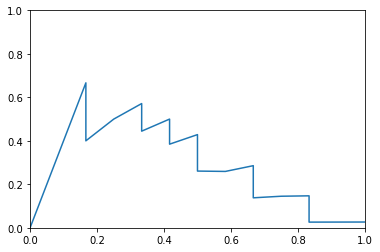

In [105]:
plt.plot(sensitivity, precision)
plt.axis([0, 1, 0, 1])

In [118]:
report_full[["%_clade_covered", "reads_clade_covered","NCBI_Taxo_id","Scientific_name"]].head(12)

,%_clade_covered,reads_clade_covered,NCBI_Taxo_id,Scientific_name
378,14.98,14984,1280,Staphylococcus aureus
323,14.71,14713,1351,Enterococcus faecalis
9,14.70,14703,562,Escherichia coli
71,14.55,14554,573,Klebsiella pneumoniae
214,5.00,5000,287,Pseudomonas aeruginosa
565,5.00,4997,817,Bacteroides fragilis
571,5.00,5000,823,Parabacteroides distasonis
344,4.94,4944,1590,Lactobacillus plantarum
158,4.91,4914,584,Proteus mirabilis
488,4.84,4837,216816,Bifidobacterium longum


In [112]:
report_full["%_clade_covered"].sum()

98.80000000000003

In [108]:
aggregated_bins.shape

(689, 4)

In [105]:
report_full.shape

(37, 6)

In [38]:
bins_summed = report_bins[report_bins.Rank == "S"].groupby("NCBI_Taxo_id").sum().reset_index()

In [42]:
bins_summed.sort_values("reads_clade_covered", ascending=False, inplace=True)

In [47]:
bins_summed["reads_clade_covered"].sum()

37235

In [48]:
bins_summed["%_clade_covered"] = bins_summed["reads_clade_covered"] / 100000

In [49]:
bins_summed

,NCBI_Taxo_id,%_clade_covered,reads_clade_covered,reads_direct_taxo
140,1280,0.03906,3906,268
67,615,0.03904,3904,54
62,573,0.03024,3024,342
174,1502,0.02149,2149,99
64,584,0.01636,1636,18
...,...,...,...,...
383,73141,0.00001,1,0
391,76860,0.00001,1,0
597,443143,0.00001,1,1
405,83455,0.00001,1,0


In [ ]:
# Fill the report with the ground truth from the summary file
report_df["Ground_truth"] = 0
true_species = summuray_df["species"].tolist()

# need to split the name to find similarities (different writing style :/ )
for i in range(len(report_df)):
    species_string = report_df["Scientific_name"].loc[i]
    species_name = ''.join(e for e in species_string if e.isalnum() or e==" ").split()  # removes special characters
    species_name += ["#don't find me"]   # stupid thing to ensure at least 2 elements
    for single_true_species in true_species:
        if species_name[0] in single_true_species and species_name[1] in single_true_species:  
            # assume a species is defined by 2 words
            report_df.loc[i, "Ground_truth"] = \
                summuray_df[summuray_df["species"]==single_true_species]["requested"].values[0]

In [141]:
report_df = report_df.reindex(columns=['%_clade_covered', 'Ground_truth', 'reads_clade_covered', 
                           'reads_direct_taxo', 'Rank', 'NCBI_Taxo_id', 'Scientific_name'], copy=False)

In [142]:
report_df.sort_values(by=["reads_clade_covered"], ascending=False, inplace=True)

In [143]:
report_df.sort_values(by=["reads_clade_covered"], ascending=False, inplace=True)

In [144]:
summuray_df

,file_name,species,taxonomy_id,kingdom,nb_of_reads,requested,available,percentage
0,Acinetobacter_baumannii_SRR5891470,Acinetobacter_baumannii,470,Bacteria,24892,833,True,8.33%
1,Bacteroides_caccae_ATCC_43185_SRR5817726,Bacteroides_caccae_ATCC_43185,411901,Bacteria,11435,833,True,8.33%
2,Blautia_hansenii_DSM_20583_SRR5817721,Blautia_hansenii_DSM_20583,537007,Bacteria,19800,833,True,8.33%
3,Borreliella_burgdorferi_SRR5434252,Borreliella_burgdorferi,139,Bacteria,17489,833,True,8.33%
4,Clostridioides_difficile_SRR5457531,Clostridioides_difficile,1496,Bacteria,1648,833,True,8.33%
5,Clostridium_bolteae_ATCC_BAA_SRR5817725,Clostridium_bolteae_ATCC_BAA,411902,Bacteria,24796,833,True,8.33%
6,Escherichia_coli_SRR6118140,Escherichia_coli,562,Bacteria,80276,833,True,8.33%
7,Helcococcus_kunzii_SRR5890147,Helcococcus_kunzii,40091,Bacteria,28880,833,True,8.33%
8,Klebsiella_pneumoniae_SRR6348587,Klebsiella_pneumoniae,573,Bacteria,68719,833,True,8.33%
9,Mesoplasma_chauliocola_SRR5997379,Mesoplasma_chauliocola,216427,Bacteria,13792,833,True,8.33%


In [145]:
report_df[report_df["Rank"] == "S"]

,%_clade_covered,Ground_truth,reads_clade_covered,reads_direct_taxo,Rank,NCBI_Taxo_id,Scientific_name
338,8.37,833,837,501,S,562,Escherichia coli
28,8.30,833,830,743,S,1496,Clostridioides difficile
702,7.90,833,790,790,S,47678,Bacteroides caccae
10,7.85,833,785,785,S,208479,[Clostridium] bolteae
15,7.65,833,765,0,S,1322,Blautia hansenii
229,7.26,833,726,726,S,216427,Mesoplasma chauliocola
230,7.11,833,711,0,S,138853,Mesoplasma lactucae
232,6.24,833,624,573,S,2151,Mesoplasma florum
415,6.19,833,619,498,S,573,Klebsiella pneumoniae
763,6.05,833,605,516,S,139,Borreliella burgdorferi


In [146]:
filtered = report_df[(report_df["Rank"] == "S") & (report_df["%_clade_covered"] > 0.00)]
filtered

,%_clade_covered,Ground_truth,reads_clade_covered,reads_direct_taxo,Rank,NCBI_Taxo_id,Scientific_name
338,8.37,833,837,501,S,562,Escherichia coli
28,8.30,833,830,743,S,1496,Clostridioides difficile
702,7.90,833,790,790,S,47678,Bacteroides caccae
10,7.85,833,785,785,S,208479,[Clostridium] bolteae
15,7.65,833,765,0,S,1322,Blautia hansenii
229,7.26,833,726,726,S,216427,Mesoplasma chauliocola
230,7.11,833,711,0,S,138853,Mesoplasma lactucae
232,6.24,833,624,573,S,2151,Mesoplasma florum
415,6.19,833,619,498,S,573,Klebsiella pneumoniae
763,6.05,833,605,516,S,139,Borreliella burgdorferi


In [147]:
print(f'{filtered.shape[0]} species have been found')

279 species have been found


### Counting correctly classified

In [148]:
report_df["TP"] = report_df[["Ground_truth", "reads_clade_covered"]].min(axis=1)
# report_df[report_df["Rank"] == "S"].head(20)

In [149]:
report_df

,%_clade_covered,Ground_truth,reads_clade_covered,reads_direct_taxo,Rank,NCBI_Taxo_id,Scientific_name,TP
1,91.07,0,9103,8,R,1,root,0
2,90.95,0,9091,21,R1,131567,cellular organisms,0
3,87.49,0,8746,26,D,2,Bacteria,0
4,46.99,0,4697,7,D1,1783272,Terrabacteria group,0
5,25.80,0,2579,15,P,1239,Firmicutes,0
333,24.93,0,2492,3,P,1224,Proteobacteria,0
6,24.49,0,2448,1,C,186801,Clostridia,0
334,24.48,0,2447,8,C,1236,Gammaproteobacteria,0
7,24.47,0,2446,5,O,186802,Clostridiales,0
224,20.91,0,2090,0,P,544448,Tenericutes,0


In [150]:
species_df = report_df[report_df["Rank"] == "S"]

In [151]:
tp = species_df["TP"].sum()
gt = summuray_df["requested"].sum()

In [152]:
print(f"There are {tp} reads correctly assigned, for a ground truth of {gt}, which is {100*tp/gt:.2f}%")

There are 7731 reads correctly assigned, for a ground truth of 9996, which is 77.34%


In [153]:
gt

9996

## Wrongly classified ?

In [154]:
report_df[(report_df["Rank"] == "S") & 
          (report_df["%_clade_covered"] > 0.00) & 
          (report_df["TP"] == 0.00)].sort_values(by=["reads_direct_taxo"], ascending=False)

,%_clade_covered,Ground_truth,reads_clade_covered,reads_direct_taxo,Rank,NCBI_Taxo_id,Scientific_name,TP
854,3.19,0,319,319,S,9606,...,0
512,0.49,0,49,48,S,48296,Acinetobacter pittii,0
514,0.40,0,40,40,S,106654,Acinetobacter nosocomialis,0
515,0.11,0,11,11,S,471,Acinetobacter calcoaceticus,0
42,0.06,0,6,6,S,1491,Clostridium botulinum,0
43,0.05,0,5,5,S,1502,Clostridium perfringens,0
440,0.18,0,18,4,S,28901,Salmonella enterica,0
517,0.04,0,4,4,S,2420305,Acinetobacter sp. FDAARGOS_560,0
433,0.04,0,4,4,S,2026240,Klebsiella quasivariicola,0
776,0.04,0,4,4,S,1674146,Borrelia mayonii,0


## Plots

In [100]:
import matplotlib.pyplot as plt

In [101]:
df_plot = report_df[report_df["Rank"] == "S"][["Scientific_name", "reads_clade_covered", "Ground_truth"]].head(20)

In [102]:
df_plot["Percentage"] = 100*df_plot["reads_clade_covered"] / df_plot["Ground_truth"]

In [103]:
df_plot.sort_values(by=["reads_clade_covered"], ascending=True, inplace=True)

In [104]:
df_plot.plot(kind='barh', x="Scientific_name", y="Percentage", 
             figsize=(8, 6), fontsize=16);

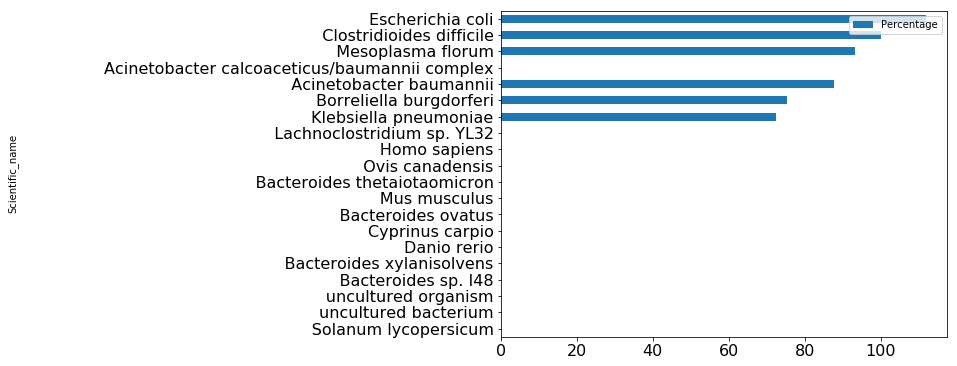

In [105]:
plt.show()

### Low level abundance species

In [106]:
low_lvl_df = report_df[report_df["Rank"]=="S"].copy()

In [107]:
low_lvl_df["wrongs"] = low_lvl_df["reads_clade_covered"] - low_lvl_df["TP"]

In [108]:
low_lvl_df = low_lvl_df[low_lvl_df["wrongs"]!=0].copy()  # remove right lines (wrongs==0)

In [109]:
low_lvl_df.sort_values(by=["wrongs"], inplace=True)

In [110]:
low_lvl_counts = low_lvl_df.wrongs.value_counts(sort=False)

In [112]:
low_lvl_counts

1      539
2      129
3       54
4       43
5       18
6       17
7       11
8        7
9       11
10       7
12       6
13       5
14       2
15       1
16       4
17       3
18       4
20       2
21       1
22       1
24       1
25       1
26       1
27       1
28       2
29       1
30       2
36       1
37       1
38       1
39       1
41       1
47       1
64       1
67       2
68       1
69       1
78       1
97       1
99       1
101      1
120      1
161      1
387      1
761      1
Name: wrongs, dtype: int64

In [113]:
abundance_lvls = 100*low_lvl_counts.index.values / gt

In [114]:
low_abundance = pd.DataFrame({'#Species': low_lvl_counts.values, 'Abundance (%)': abundance_lvls, }, )

In [115]:
low_abundance

,#Species,Abundance (%)
0,539,0.010004
1,129,0.020008
2,54,0.030012
3,43,0.040016
4,18,0.050020
5,17,0.060024
6,11,0.070028
7,7,0.080032
8,11,0.090036
9,7,0.100040


In [116]:
low_abundance.plot(logx=True, logy=True, x='Abundance (%)', y='#Species',
                    figsize=(8, 6), fontsize=12, title="Number of wrongly detected species for a given abundance threshold")

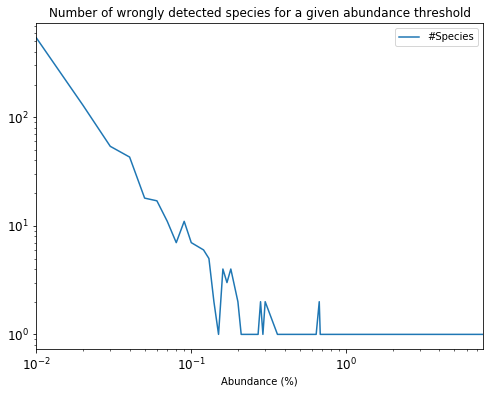

In [117]:
plt.show()

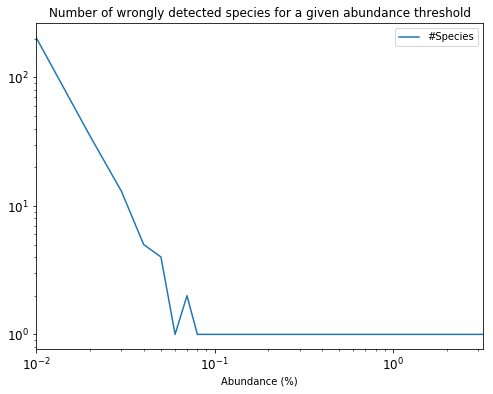

In [62]:
plt.show()

In [ ]:
# Good pandas plots
# http://queirozf.com/entries/pandas-dataframe-plot-examples-with-matplotlib-pyplot
# https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html

In [ ]:
# summuray_df[['species', 'taxonomy_id', 'kingdom', 'nb_of_reads',
#        'requested', 'available', 'percentage']]